<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [145]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 31.78 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16678 sha256=65e2b90356448741ae027c544d846e9d31f6289f0bfbcee7fba5e92e69b2d2bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-6zqzi1e6/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [146]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


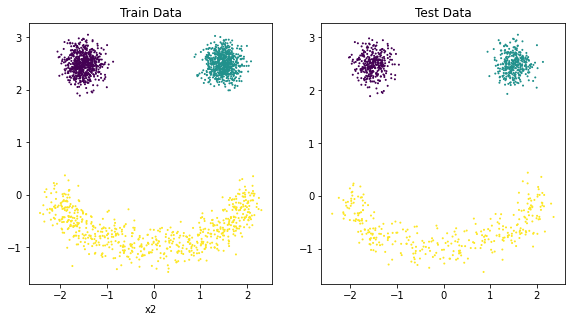

Dataset 2


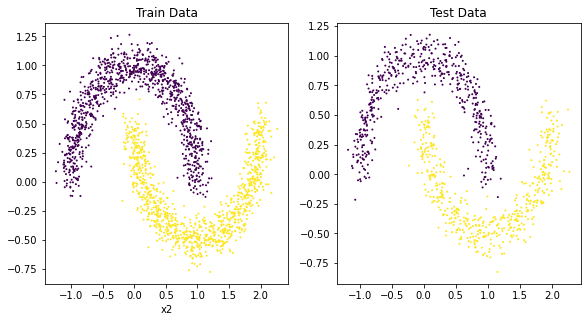

In [152]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [205]:
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import copy
import deepul.pytorch_util as ptu
import torch.distributions as tch_distrib
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.auto import tqdm

In [206]:
class MixtureCDF(nn.Module):
    
    def __init__(self, n=4):
        super().__init__()
        self.mu = nn.Parameter(torch.randn(n), requires_grad=True)
        self.sigma = nn.Parameter(torch.zeros(n), requires_grad=True)
        self.wlogits = nn.Parameter(torch.zeros(n), requires_grad=True)
        self.uniformdist = tch_distrib.uniform.Uniform(0.0, 1.0)

    def forward(self, x):
        bs = len(x)
        weights = self.wlogits.softmax(dim=0).unsqueeze(0).repeat(bs, 1)
        xrep = x.unsqueeze(1).repeat(1, len(self.mu))

        z = tch_distrib.normal.Normal(self.mu, self.sigma.exp())
        z = z.cdf(xrep)
        z = z * weights
        z = z.sum(dim=1)

        log_det = tch_distrib.normal.Normal(self.mu, self.sigma.exp())
        log_det = log_det.log_prob(xrep).exp()
        log_det = log_det * weights
        log_det = log_det.sum(dim=1).log()

        return z, log_det
 
    def getloss(self, x):
        z, log_det = self(x)
        log_prob = self.uniformdist.log_prob(z) + log_det
        return - logprob.mean()


class MLP(nn.Module):

    def __init__(self, d_input, n_layers, d_hidden, d_out):
        super().__init__()
        layers = []

        layers += [nn.Linear(d_input, d_hidden)]
        layers += [nn.ReLU()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(d_hidden, d_hidden)]
            layers += [nn.ReLU()]
        layers += [nn.Linear(d_hidden, d_out)]

        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [202]:
class ARFlow(nn.Module):

    def __init__(self, n=5):
        super().__init__()
        self.flow = MixtureCDF(n=n)
        self.mlp = MLP(d_input=1, n_layers=3, d_hidden=64, d_out=3*n)
        self.n = n
        self.uniformdist = tch_distrib.uniform.Uniform(0.0, 1.0)

    def forward(self, x):
        # (bs, 2) -> (bs, 1) (bs, 1)
        x1, x2 = torch.chunk(x, 2, dim=1)

        z1, log_det1 = self.flow(x1.squeeze())
        mlp_out = self.mlp(x1)
        mu, sigma, wlogits = torch.chunk(mlp_out, 3, dim=1)
        w = F.softmax(wlogits, dim=1)

        x2rep = x2.repeat(1, self.n)

        z2 = tch_distrib.normal.Normal(mu, sigma.exp())
        z2 = z2.cdf(x2rep)
        z2 = w * z2
        z2 = z2.sum(dim=1)

        log_det2 = tch_distrib.normal.Normal(mu, sigma.exp())
        log_det2 = log_det2.log_prob(x2rep).exp()
        log_det2 = w * log_det2
        log_det2 = log_det2.sum(dim=1).log()

        z = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
        log_det = torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

        return z, log_det

    def log_prob(self, x):
        z, log_det = self(x)
        return (self.uniformdist.log_prob(z) + log_det).mean(dim=1)

    def getloss(self, x):
        z, log_det = self(x)
        log_prob = (self.uniformdist.log_prob(z) + log_det).mean(dim=1)
        return - log_prob.mean()

In [147]:
class Trainer:

    def __init__(self, model, device, train_loader, test_loader, epochs, lr):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.lr = lr
    
    def _optim_step(self, loss):
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
    
    def _train(self):
        self.model.train()

        for batch in self.train_loader:
            batch = batch.to(self.device).float().contiguous()
            loss = self.model.getloss(batch)
            self._optim_step(loss)
            self.train_losses.append(loss.item())
    
    @torch.no_grad()
    def _test(self):
        self.model.eval()
        loss = 0.

        for batch in self.test_loader:
            batch = batch.to(self.device).float().contiguous()
            loss += self.model.getloss(batch) * len(batch)
            
        loss /= len(self.test_loader.dataset)
        self.test_losses.append(loss.item())
    
    def _prepare_tools(self):
        self.optim = optim.Adam(self.model.parameters(), lr=self.lr)
        self.train_losses = []
        self.test_losses = []
        self._test()
    
    def run(self):
        self._prepare_tools()

        for epoch in tqdm(range(self.epochs), leave=False):
            self._train()
            self._test()
        
        return self.train_losses, self.test_losses


In [204]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets, or
                for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """

    """ YOUR CODE HERE """
    BATCH_SIZE = 128
    SHUFFLE = True
    DEVICE = torch.device("cpu")
    #DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 150
    LR = 5e-3

    # create data loaders
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # model
    model = ARFlow()

    # train
    trainer = Trainer(model, DEVICE, train_loader, test_loader, EPOCHS, LR)
    train_losses, test_losses = trainer.run()

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    densities = np.exp(ptu.get_numpy(model.log_prob(mesh_xs)))

    # latents
    z, _ = model(torch.FloatTensor(train_data))
    latents = z.detach().cpu().numpy()

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.6676


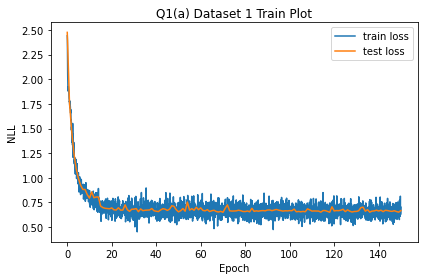

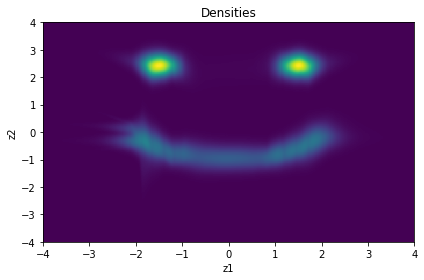

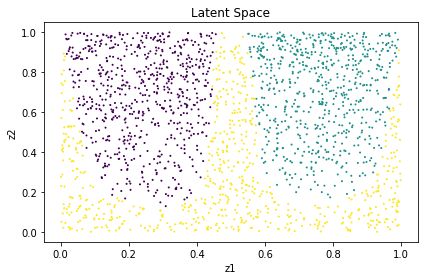

In [207]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 0.5342


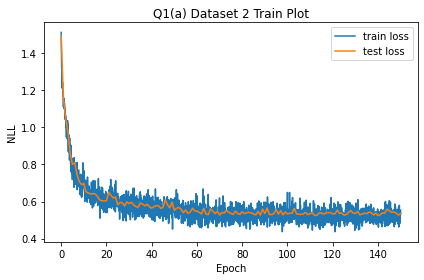

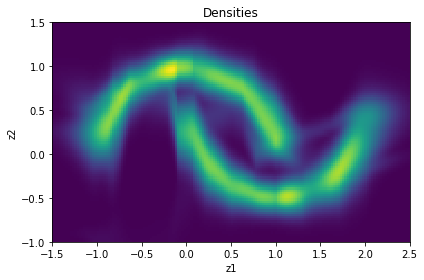

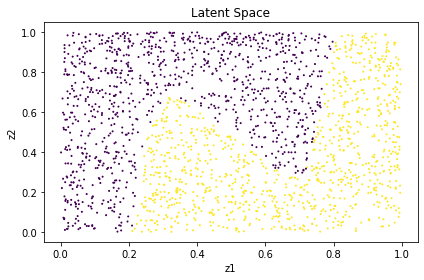

In [208]:
q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [199]:
class MLP(nn.Module):

    def __init__(self, d_input, n_layers, d_hidden, d_out):
        super().__init__()
        layers = []

        layers += [nn.Linear(d_input, d_hidden)]
        layers += [nn.ReLU()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(d_hidden, d_hidden)]
            layers += [nn.ReLU()]
        layers += [nn.Linear(d_hidden, d_out)]

        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)


class Affine(nn.Module):

    def __init__(self, mask):
        super().__init__()
        self.mask = mask
        self.mu = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.sigma = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.model = MLP(d_input=2, n_layers=2, d_hidden=64, d_out=2)

    def forward(self, x):
        log_s, t = self.common(x)
        return x * torch.exp(log_s) + t, log_s
    
    def backward(self, x):
        log_s, t = self.common(x)
        return (x - t) * torch.exp(-log_s), log_s
    
    def common(self, x):
        bs = len(x)
        mask = self.mask.repeat(bs, 1)

        log_s, t = self.model(x * mask).split(1, dim=1)
        log_s = self.mu * torch.tanh(log_s) + self.sigma

        return log_s * (1.0 - mask), t * (1.0 - mask)


class RealNVP(nn.Module):

    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms
        
    def forward(self, x):
        log_det = torch.zeros_like(x)
        for trf in self.transforms:
            x, _log_det = trf.forward(x)
            log_det += _log_det
        return x, log_det

    def reverse(self, z):
        for trf in reversed(self.transforms):
            z, _ = trf.backward(z)
        return z

    def sample(self, n):
        dnormal = tch_distrib.normal.Normal(torch.tensor(0.), torch.tensor(1.))
        z = dnormal.sample([n, 2])
        return self.reverse(z)

    def getloss(self, x):
        z, log_det = self(x)
        dnormal = tch_distrib.normal.Normal(torch.tensor(0.), torch.tensor(1.))
        log_prob = torch.sum(log_det, dim=1) + torch.sum(dnormal.log_prob(z), dim=1)
        return - log_prob.mean()
    
    def log_prob(self, x):
        z, log_det = self(x)
        dnormal = tch_distrib.normal.Normal(torch.tensor(0.), torch.tensor(1.))
        return torch.sum(log_det, dim=1) + torch.sum(dnormal.log_prob(z), dim=1)

In [200]:
def q1_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets, or
                for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in R^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """

    """ YOUR CODE HERE """
    BATCH_SIZE = 128
    SHUFFLE = True
    DEVICE = torch.device("cpu")
    #DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 300
    LR = 5e-3
    N_TRANSFORMS = 3

    # create data loaders
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # model
    transforms = []
    for _ in range(N_TRANSFORMS):
        transforms += [Affine(torch.FloatTensor([1.0, 0.0])),
                       Affine(torch.FloatTensor([0.0, 1.0]))]
    model = RealNVP(nn.ModuleList(transforms))

    # train
    trainer = Trainer(model, DEVICE, train_loader, test_loader, EPOCHS, LR)
    train_losses, test_losses = trainer.run()

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    densities = np.exp(ptu.get_numpy(model.log_prob(mesh_xs)))

    # latents
    z, _ = model(torch.FloatTensor(train_data))
    latents = z.detach().cpu().numpy()

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 1.4754


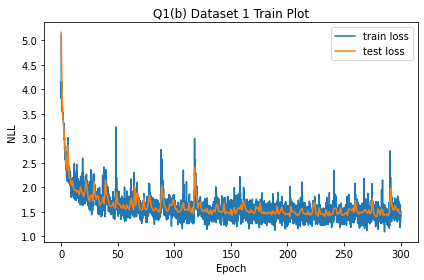

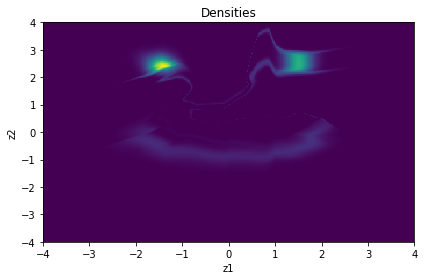

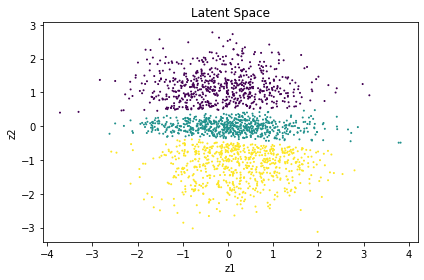

In [201]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 1.1728


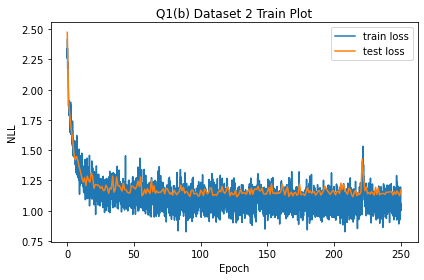

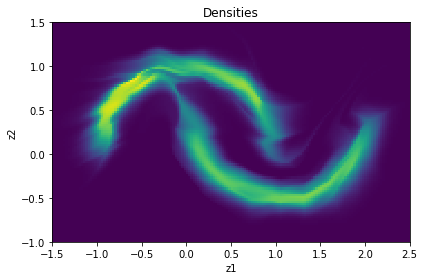

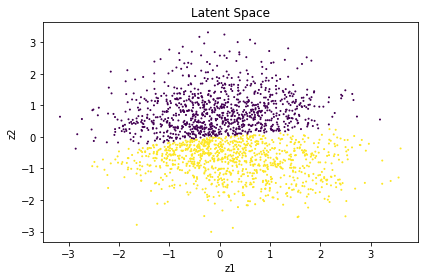

In [182]:
q1_save_results(2, 'b', q1_b)

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

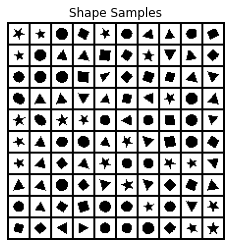

In [5]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [148]:
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import copy
import deepul.pytorch_util as ptu
import torch.distributions as tch_distrib
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
from itertools import permutations

In [149]:
class TrainerQ2(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        a, b = torch.tensor(0.0).to(self.device), torch.tensor(0.5).to(self.device)
        self.qdistrib = tch_distrib.Uniform(a, b)

    def _train(self):
        self.model.train()

        for batch in self.train_loader:
            batch = batch.to(self.device).float().contiguous()
            batch += self.qdistrib.sample(batch.shape)
            loss = self.model.getloss(batch)
            self._optim_step(loss)
            self.train_losses.append(loss.item())

In [181]:
class MaskConv(nn.Conv2d):

    def __init__(self, *args, **kwargs):
        init = kwargs.pop('init') if 'init' in kwargs else False
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        k = self.kernel_size[0]
        self.mask[:, :, :k//2, :] = 1
        self.mask[:, :, k//2, :k//2] = 1
        self.mask[:, :, k//2, k//2] = 1 * (init is False)

    def forward(self, input):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return out


class PixelCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.ModuleList()        
        self.model += [MaskConv(in_channels=1, out_channels=128, kernel_size=7, padding=7//2, init=True)]
        for _ in range(4):
            self.model += [nn.LayerNorm(128),
                           nn.ReLU(),
                           MaskConv(in_channels=128, out_channels=128, kernel_size=7, padding=7//2)]
        self.model += [nn.ReLU(),
                       MaskConv(in_channels=128, out_channels=128, kernel_size=1),
                       nn.ReLU(),
                       MaskConv(in_channels=128, out_channels=30, kernel_size=1),]

    def forward(self, x):
        bs, _, h, w = x.size()
        for layer in self.model:
            if isinstance(layer, nn.LayerNorm):
                x = x.permute(0, 2, 3, 1)
                x = layer(x)
                x = x.permute(0, 3, 1, 2)
            else:
                x = layer(x)
        x = x.view(bs, 30, 1, h, w)
        return x

    def getloss(self, x):
        out = self(x)
        mu, sigma, _ = torch.chunk(out, 3, dim=1)

        x = x.unsqueeze(1).repeat(1, 1, 30, 1, 1)
        J = tch_distrib.Normal(mu, sigma.exp())
        J = - J.log_prob(x).mean()

        return J

In [182]:
def q2(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
        and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    """

    """ YOUR CODE HERE """
    # args
    BATCH_SIZE = 128
    SHUFFLE = True
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 10
    LR = 3e-3

    # prepare data
    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
    test_data = test_data + np.random.uniform(high=0.5, size=test_data.shape)

    # dataloaders
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # model
    model = PixelCNN().to(DEVICE)

    # train
    trainer = TrainerQ2(model, DEVICE, train_loader, test_loader, EPOCHS, LR)
    train_losses, test_losses = trainer.run()

    # make samples
    _, _, h, w = train_data.shape
    assert h == w == 20
    with torch.no_grad():
        samples = torch.zeros(100, 1, h, w).to(DEVICE)

        for a in range(20):
            for b in range(20):
                mu, sigma, wlogits = torch.chunk(model(samples), 3, dim=1)
                mu, sigma, wlogits = mu[:,:,0,a,b], sigma[:,:,0,a,b], wlogits[:,:,0,a,b]

                c = torch.multinomial(wlogits.softmax(dim=1), 1).squeeze(-1)
                sampleslice = torch.arange(100)
                mu = mu[sampleslice, c]
                sigma = sigma[sampleslice, c].exp()

                samples[:, 0, a, b] = torch.normal(mu, sigma)
        
        samples = samples.detach().permute(0, 2, 3, 1).cpu().numpy()

    # ommit np.log(2)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Final Test Loss: -0.4470


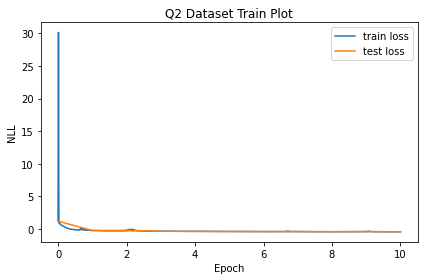

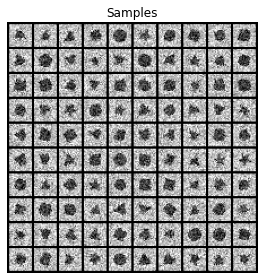

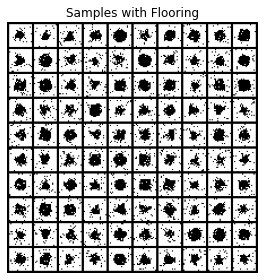

In [183]:
q2_save_results(q2)

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



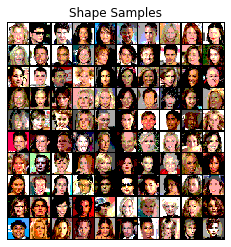

In [ ]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



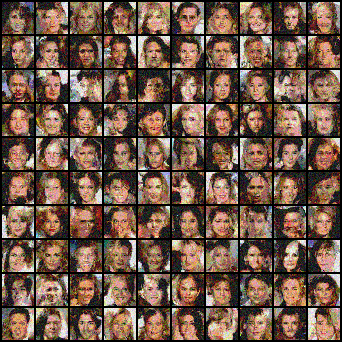

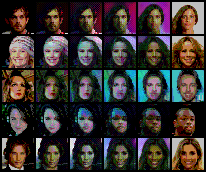

In [ ]:
q3_save_results(q3_a, 'a')

## Part (b): Exploring bad masking schemes [10pt]

As shown in lecture, the choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [ ]:
def q3_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

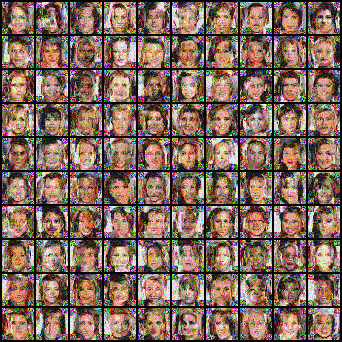

In [ ]:
q3_save_results(q3_b, 'b')

# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP [10pt]
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_a, 'bonus_a')

## Q4(b): Glow [5pt]
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_b, 'bonus_b')

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)